#2: Exploratory Data Analysis
# Data Science - Capstone Project Submission

* Student Name: **James Toop**
* Student Pace: **Self Paced**
* Scheduled project review date/time: **29th October 2021 @ 21:30 BST**
* Instructor name: **Jeff Herman / James Irving**
* Blog URL: **https://toopster.github.io/**

---

## Table of Contents
1. [Business Case, Project Purpose and Approach](1_business_case.ipynb#business-case)
    1. [The importance of communication for people with severe learning disabilities](1_business_case.ipynb.ipynb#communication-and-learning-disabilities)
    2. [Types of communication](1_business_case.ipynb.ipynb#types-of-communication)
    3. [Communication techniques for people with learning disabilities](1_business_case.ipynb.ipynb#communication-techniques)
    4. [Project purpose & approach](1_business_case.ipynb.ipynb#project-purpose)
2. [Exploratory Data Analysis](#eda)
    1. [The Datasets](#the-datasets)
    2. [Discovery](#data-discovery)
    3. [Preprocessing - Stage One](#data-preprocessing-stage-one)
3. [Deep Learning Models](3_deep_learning_models.ipynb#deep-learning-models)
    1. [Preprocessing - Stage Two](3_deep_learning_models.ipynb#data-preprocessing-stage-two)
    2. [Initial Model Using Spectrograms](3_deep_learning_models.ipynb#model-1)
    3. [Advanced Model using MFCC's](3_deep_learning_models.ipynb#model-2)
4. [Final Model Performance Evaluation](#final-model-performance-evaluation)

---
<a name="eda"></a>
## 2. Exploratory Data Analysis


<a name="the-datasets"></a>
### 2A. The Datasets


#### Speech Commands: A dataset for limited-vocabulary speech recognition –
https://arxiv.org/abs/1804.03209

The Speech Commands dataset is an attempt to build a standard training and evaluation dataset for a class of simple speech recognition tasks. Its primary goal is to provide a way to build and test small models that detect when a single word is spoken, from a set of ten or fewer target words, with as few false background noise or unrelated speech.


#### Ultrasuite: A collection of ultrasound and acoustic speech data from child speech therapy sessions –
https://ultrasuite.github.io/

Ultrasuite is a collection of ultrasound and acoustic speech data from child speech therapy sessions. The current release includes three datasets, one from typically developing children and two from speech disordered children:

* **Ultrax Typically Developing (UXTD)** -  A dataset of 58 typically developing children. 
* **Ultrax Speech Sound Disorders (UXSSD)** - A dataset of 8 children with speech sound disorders. 
* **UltraPhonix (UPX)** - A second dataset of children with speech sound disorders, collected from 20 children.

**IMPORTANT NOTE:**

The datasets have not been included in the GitHub repository with this notebook and will need to be downloaded and
stored in the local repository for the code to run correctly.  

The code below will however, download, store and transform the datasets as required for the models to run.

<a name="data-discovery"></a>
### 2B. Data Discovery

This section presents an initial step to investigate, understand and document the available data fields and relationships, highlighting any potential issues / shortcomings within the datasets supplied.

In [175]:
# Import required libraries and modules for data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import soundfile as sf
import librosa, librosa.display
import IPython.display as ipd
import os

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

import pathlib
from pathlib import Path
import shutil
import collections
import nltk

#### Download Speech Commands v0.02 dataset

The Speech Commands dataset contains audio samples in `.wav` format, no longer than 1 second and with a sample rate of `16000` and has been organised such that each audio sample is stored within a folder that has been named so that is corresponds with it's associated label as per the following example:

```
└── speech_commands_v0.02

    ├── backward
    
        ├── 0a2b400e_nohash_0.wav
        ├── 0a2b400e_nohash_1.wav
        ├── 0a2b400e_nohash_2.wav
        ├── 0a2b400e_nohash_3.wav
        ├── 0a396ff2_nohash_0.wav
        └── ...
        
    ├── bed    
    
        ├── 0a7c2a8d_nohash_0.wav
        └── ...
```

In [2]:
# Function to download the Speech Commands dataset, unpack and remove unnecessary files
def download_speech_commands():
    
    data_dir = pathlib.Path('data/speech_commands_v0.02')
    
    # Check to see if data directory already exists, download if not
    if not data_dir.exists():
        tf.keras.utils.get_file(
            'speech_commands_v0.02.zip',
            origin='http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
            extract=True,
            cache_dir='.',
            cache_subdir='data/speech_commands_v0.02')
    else:
        print('Speech Commands dataset already exists')
        
    # Remove the _background_noise_ samples as these are not required
    try:
        shutil.rmtree(str(data_dir) + '/_background_noise_')
    except OSError as e:
        print('Error: %s - %s.' % (e.filename, e.strerror), 'Check if directory has already been removed.')
    
    
    # Remove the extracted zip file for politeness as this is also not required
    zip_file = str(data_dir) + '/speech_commands_v0.02.zip'
    if os.path.exists(zip_file):
        os.remove(zip_file)

In [141]:
# Call the function to download the Speech Commands v0.02 dataset
download_speech_commands()

Speech Commands dataset already exists
Error: data/speech_commands_v0.02/_background_noise_ - No such file or directory. Check if directory has already been removed.


#### Preview audio samples and waveforms from Speech Commands dataset

In [194]:
# Load the audio sample and preview
target_sample = 'data/speech_commands_v0.02/zero/0a2b400e_nohash_0.wav'
sc_sample, sr = librosa.load(target_sample)
print('Audio sample: Zero')
ipd.Audio(sc_sample, rate=sr)

Audio sample: Zero


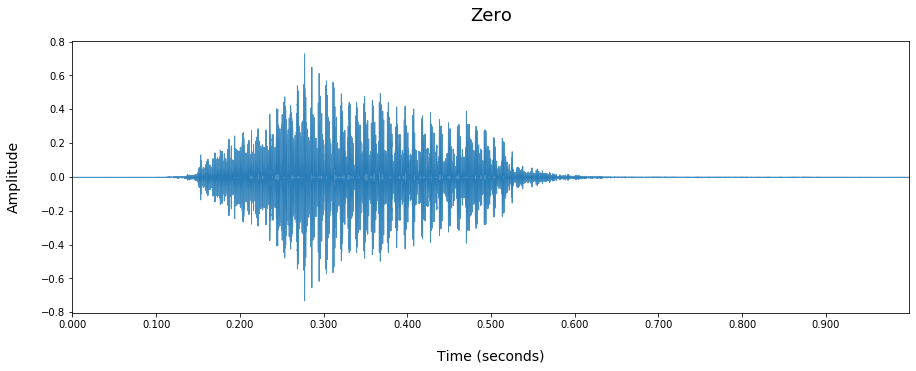

In [252]:
# Plot the waveform for the specific audio sample
plt.figure(figsize=(15, 5))
plt.title('Zero', fontsize=18, pad=20)
librosa.display.waveplot(sc_sample, sr, alpha=0.8)
plt.xlabel('Time (seconds)', fontsize=14, labelpad=20)
plt.ylabel('Amplitude', fontsize=14, labelpad=20)
plt.show();

In [192]:
# Extract the short time Fourier transform
hop_length = 512
n_fft = 2048

S_sc_sample = librosa.stft(sc_sample, n_fft=n_fft, hop_length=hop_length)
S_sc_sample.shape

(1025, 44)

In [193]:
type(S_sc_sample[0][0])

numpy.complex64

In [198]:
# Calculating the spectrogram
Y_sc_sample = np.abs(S_sc_sample) ** 2

In [246]:
# Function to visualise the spectrogram
def plot_spectrogram(Y, sr, hop_length, y_axis='linear'):
    fig = plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis='time', 
                             y_axis=y_axis)
    fig.gca().set_xlabel('Time (seconds)', fontsize=18, labelpad=20)
    fig.gca().set_ylabel('Frequency (Hz)', fontsize=18, labelpad=20)
    plt.colorbar(format='%+2.f')

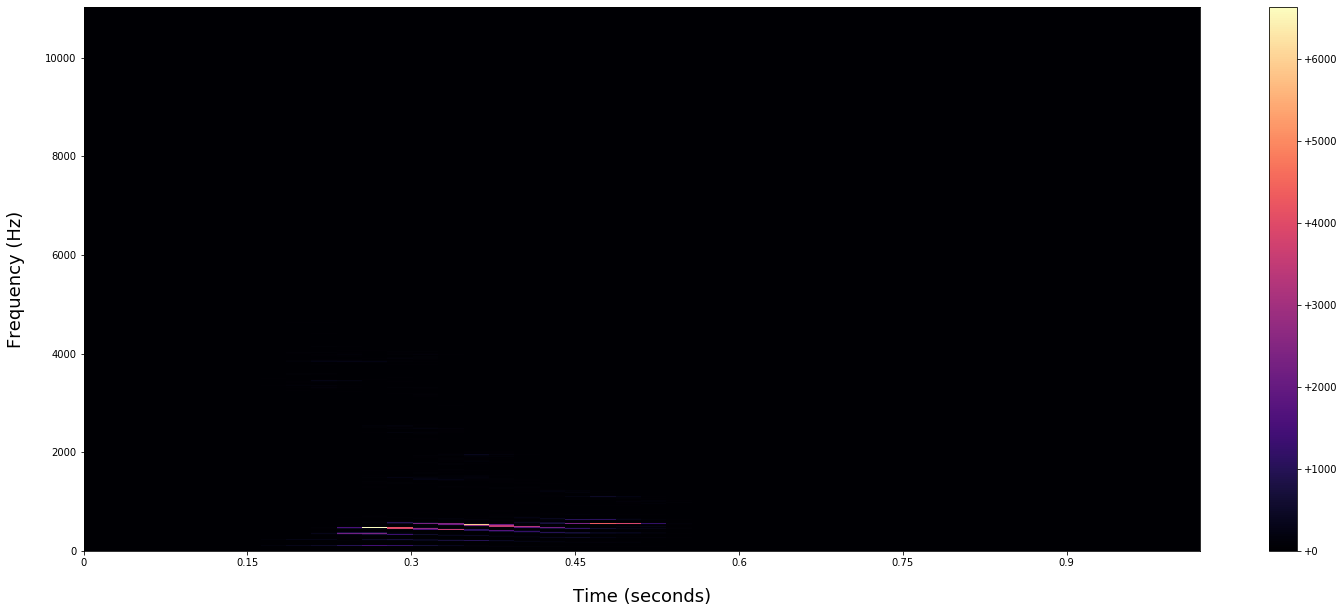

In [247]:
plot_spectrogram(Y_sc_sample, sr, hop_length)

The human perception of sound intensity is logarithmic in nature so we are interested in the log amplitude.

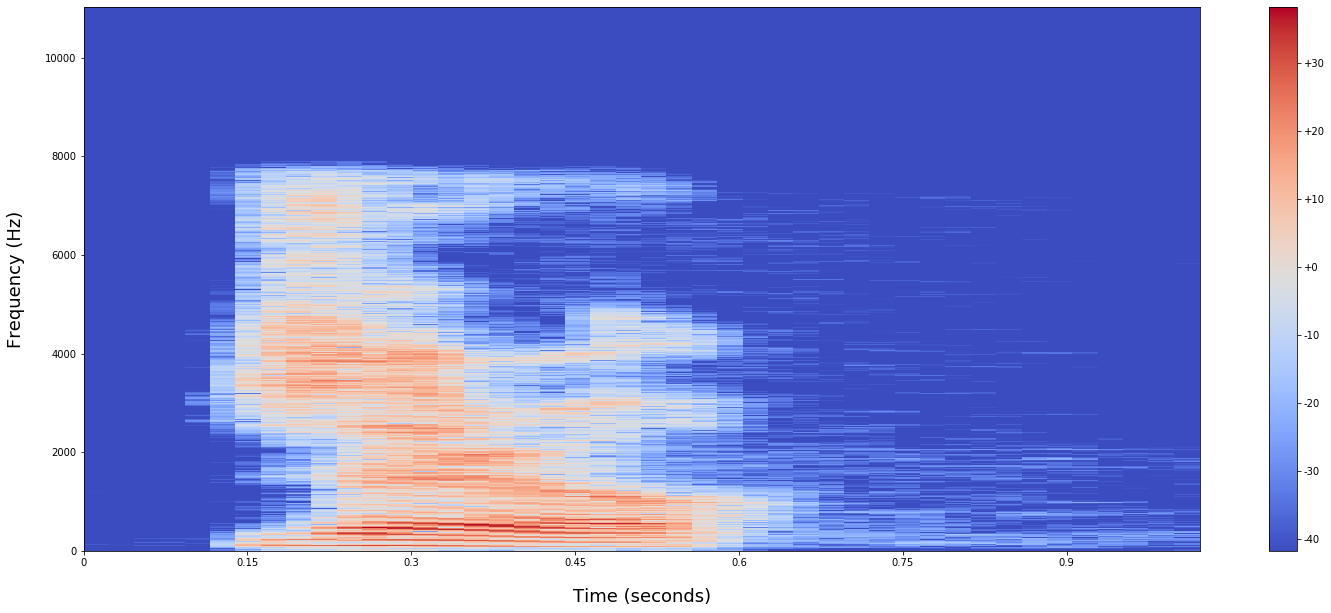

In [227]:
# Display spectrogram using log amplitude
Y_log_sc_sample = librosa.power_to_db(Y_sc_sample)
plot_spectrogram(Y_log_sc_sample, sr, hop_length)

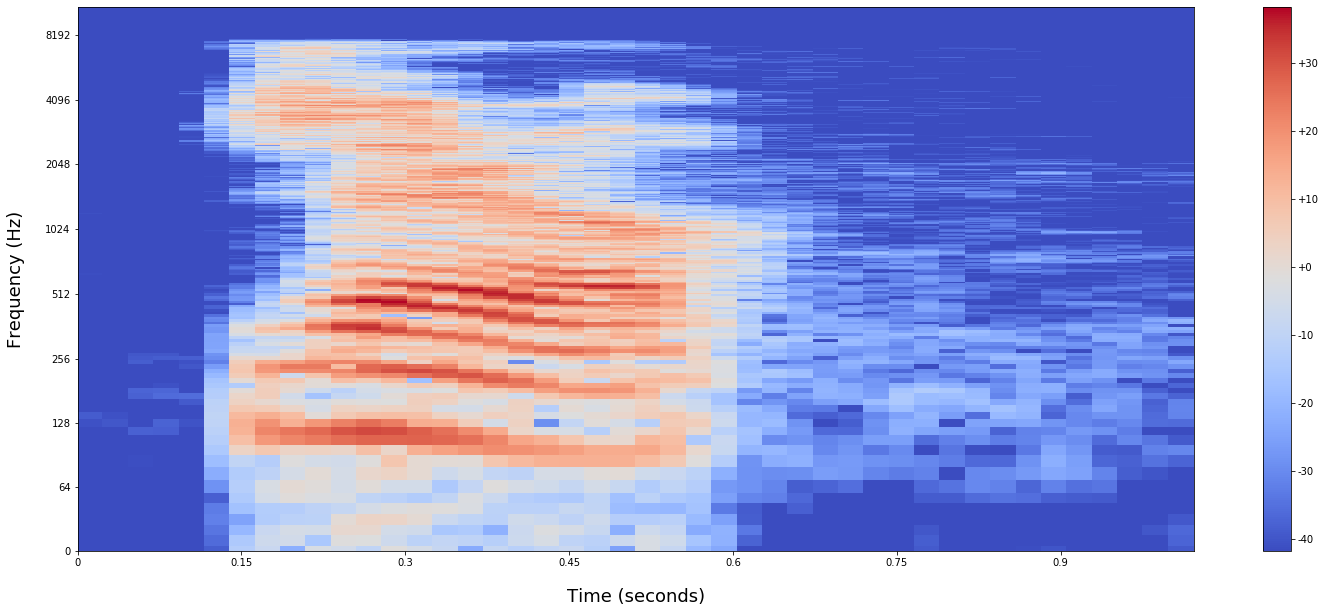

In [228]:
# Display spectrogram using log frequency
plot_spectrogram(Y_log_sc_sample, sr, hop_length, y_axis='log')

#### Download the Ultrasuite dataset

In order to prepare the datasets prior to training the neural network, we need to download, splice and label each of the audio samples from the Ultrasuite datasets. We also need to transform them into the same structure as the Speech Commands dataset.

Currently each dataset is organised by a child subject ID, session, and then sample ID, for example:

```
└── ultrasuite

    ├── core-uxssd
    
        ├── core
        
            ├── 01M  (Child ID)
            
                ├── BL1  (Session ID)
    
                    ├── 001A.wav (Sample ID)
                    ├── 002A.wav
                    ├── 003A.wav
                    ├── 004A.wav
                    ├── 005A.wav
                    └── ...
        
                ├── Maint1    
    
                    ├── 001A.wav
                    ├── 002A.wav                    
                    ├── 003A.wav                    
                    └── ...
```

In addition, each audio sample is given a "grading", A - E that denotes the decreasing quality of the audio sample and capture.  As a result, labels are not typically supplied for grades D and E.

In [4]:
# Function for downloading the Ultrasuite datasets
# def download_ultrasuite(datasets):
    
#     for dataset in datasets:
#         os.system('rsync -av ultrasuite-rsync.inf.ed.ac.uk::ultrasuite/core-uxtd')

#### Preview audio samples, waveforms, spectrograms and labels from Ultrasuite dataset

In [262]:
# Load the audio sample and preview
target_sample = 'data/ultrasuite/core-uxssd/core/06M/BL1/002A.wav'
us_sample, sr = librosa.load(target_sample)
print('Audio sample: Car | Girl | Moon | Knife')
ipd.Audio(us_sample, rate=sr)

Audio sample: Car | Girl | Moon | Knife


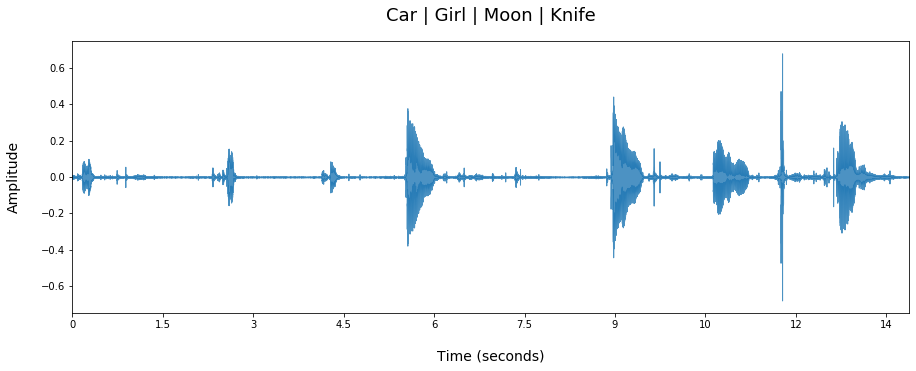

In [263]:
# Plot the waveform for the specific audio sample
plt.figure(figsize=(15, 5))
plt.title('Car | Girl | Moon | Knife', fontsize=18, pad=20)
librosa.display.waveplot(us_sample, sr, alpha=0.8)
plt.xlabel('Time (seconds)', fontsize=14, labelpad=20)
plt.ylabel('Amplitude', fontsize=14, labelpad=20)
plt.show();

In [5]:
# Function for extracting and combining labels from all .lab files into a single DataFrame
def all_ultrasuite_word_labels(src_directory, src_dataset):
    
    directory = src_directory + src_dataset + '/word_labels/lab/'
    columns = ['start_time', 'end_time', 'utterance']
    all_labels_df = pd.DataFrame()

    for filename in os.listdir(directory):
    
        filepath = directory + filename
    
        labels_df = pd.read_csv(filepath, sep=" ", header=None, names=columns)
    
        # Extract the speaker, session and speech data from the filename and add to the dataframe
        labels_df['dataset'] = src_dataset
        labels_df['speaker'] = filename[0:3]
        if len(filename[4:-9]) == 0:
            labels_df['session'] = None
        else:
            labels_df['session'] = filename[4:-9]
        labels_df['speech_waveform'] = filename[-8:-4]

        # Tidy up data formatting and correct time based units
        labels_df['utterance'] = labels_df['utterance'].str.lower()
        labels_df['start_time'] = pd.to_timedelta(labels_df['start_time'] * 100)
        labels_df['end_time'] = pd.to_timedelta(labels_df['end_time'] * 100)

        # Append incoming labels to existing dataframe
        all_labels_df = all_labels_df.append(labels_df, ignore_index=True)
    
    return all_labels_df

In [6]:
# Load the labels for the Ultrax Speech Sound Disorders dataset
uxssd_df = all_ultrasuite_word_labels('data/ultrasuite/labels-uxtd-uxssd-upx/', 'uxssd')

In [7]:
# Preview the data
uxssd_df.head()

,start_time,end_time,utterance,dataset,speaker,session,speech_waveform
0,00:00:01.340000,00:00:02.040000,th,uxssd,02M,BL1,069B
1,00:00:02.460000,00:00:03.350000,atha,uxssd,02M,BL1,069B
2,00:00:03.790000,00:00:04.650000,eethee,uxssd,02M,BL1,069B
3,00:00:05.210000,00:00:06.110000,otho,uxssd,02M,BL1,069B
4,00:00:00.970000,00:00:01.480000,core,uxssd,04M,Maint1,017A


In [8]:
# Load the labels for the Ultrax Typically Developing dataset
uxtd_df = all_ultrasuite_word_labels('data/ultrasuite/labels-uxtd-uxssd-upx/', 'uxtd')

In [9]:
# Preview the data
uxtd_df.head()

,start_time,end_time,utterance,dataset,speaker,session,speech_waveform
0,00:00:07.300000,00:00:08.180000,watch,uxtd,37M,None,001A
1,00:00:08.270000,00:00:09.219999,fishing,uxtd,37M,None,001A
2,00:00:09.539999,00:00:10.500000,gloves,uxtd,37M,None,001A
3,00:00:10.640000,00:00:11.520000,spider,uxtd,37M,None,001A
4,00:00:01.170000,00:00:02.020000,r,uxtd,30F,None,010B


In [10]:
# Preview the dataframe info
uxtd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6094 entries, 0 to 6093
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   start_time       6094 non-null   timedelta64[ns]
 1   end_time         6094 non-null   timedelta64[ns]
 2   utterance        6094 non-null   object         
 3   dataset          6094 non-null   object         
 4   speaker          6094 non-null   object         
 5   session          0 non-null      object         
 6   speech_waveform  6094 non-null   object         
dtypes: object(5), timedelta64[ns](2)
memory usage: 333.4+ KB


In [11]:
# Load the labels for the Ultraphonix dataset
upx_df = all_ultrasuite_word_labels('data/ultrasuite/labels-uxtd-uxssd-upx/', 'upx')

In [12]:
# Preview the data
upx_df.head()

,start_time,end_time,utterance,dataset,speaker,session,speech_waveform
0,00:00:00,00:00:01.400000,sigh,upx,20M,Post,012A
1,00:00:01.639999,00:00:02.910000,sausages,upx,20M,Post,012A
2,00:00:03.140000,00:00:03.970000,snail,upx,20M,Post,012A
3,00:00:04.890000,00:00:05.699999,beige,upx,20M,Post,012A
4,00:00:00.510000,00:00:01.240000,sack,upx,16M,BL3,016A


<a name="data-preprocessing-stage-one"></a>
### 2C. Preprocessing - Stage One

#### Transform the Ultrasuite dataset

Unlike the Speech Commands dataset, each audio sample in it's raw format contains multiple utterances that are spoken by both the Speech Therapist and the child subject.  

The labels for each `.wav` file have been stored in a separate `.lab` file together with timestamps for the start and end of each utterance. The following is an example for the audio clip previewed earlier:

```
54700000 60900000 CAR
88800000 94800000 GIRL
109500000 112999999 MOON
126100000 136400000 KNIFE
```

In order to get the audio samples from the Ultrasuite datasets into the appropriate format for the Deep Learning models, we will need to splice the raw audio samples according to these timestamps.

In [13]:
# Function for extracting labels from .lab file into a single DataFrame
def ultrasuite_word_labels(src_dataset, src_file):
    
    filepath = 'data/ultrasuite/labels-uxtd-uxssd-upx/' + src_dataset + '/word_labels/lab/' + src_file

    columns = ['start_time', 'end_time', 'utterance']
    word_labels_df = pd.DataFrame()
    word_labels_df = pd.read_csv(filepath, sep=" ", header=None, names=columns)
    
    # Extract the speaker, session and speech data from the filename and add to the dataframe
    word_labels_df['dataset'] = src_dataset
    word_labels_df['speaker'] = src_file[0:3]
    if len(src_file[4:-9]) == 0:
        word_labels_df['session'] = None
    else:
        word_labels_df['session'] = src_file[4:-9]
    word_labels_df['speech_waveform'] = src_file[-8:-4]

    # Tidy up data formatting and correct time based units
    word_labels_df['utterance'] = word_labels_df['utterance'].str.lower()
    word_labels_df['start_time'] = pd.to_timedelta(word_labels_df['start_time'] * 100)
    word_labels_df['end_time'] = pd.to_timedelta(word_labels_df['end_time'] * 100)
    
    return word_labels_df

In [14]:
# Quick test to check function works for a single labels file
upx_01F_df = ultrasuite_word_labels('upx', '01F-BL1-005A.lab')
upx_01F_df.head()

,start_time,end_time,utterance,dataset,speaker,session,speech_waveform
0,00:00:00,00:00:00.620000,teeth,upx,01F,BL1,005A
1,00:00:03.860000,00:00:04.650000,watch,upx,01F,BL1,005A
2,00:00:06.160000,00:00:06.780000,orange,upx,01F,BL1,005A
3,00:00:09.050000,00:00:09.980000,school,upx,01F,BL1,005A


In [15]:
# Function for splicing original *.wav file based on timestamps
def extract_segments(y, sr, segments, dataset):
    
    # Compute segment regions in number of samples
    starts = np.floor(segments.start_time.dt.total_seconds() * sr).astype(int)
    ends = np.ceil(segments.end_time.dt.total_seconds() * sr).astype(int)
    
    isolated_directory = 'data/ultrasuite_isolated/' + dataset + '/'

    if not os.path.isdir(isolated_directory):
        os.makedirs(isolated_directory.strip('/'))
    
    i = 0
    # Slice the audio into segments
    for start, end in zip(starts, ends):
        audio_seg = y[start:end]
        print('extracting audio segment:', len(audio_seg), 'samples')
        
        # Set the file path for the spliced audio file    
        file_path = isolated_directory + str(segments.speaker[i]) + '/'
        if segments.session[i] != None:
            file_path = file_path + str(segments.session[i]) + '/' 
        file_path = file_path + str(segments.speech_waveform[i]) + '/'
            
        if not os.path.isdir(file_path):
            os.makedirs(file_path.strip('/')) 
            
        file_name = file_path + str(segments.utterance[i]) + '.wav'
        
        sf.write(file_name, audio_seg, sr)
        i += 1

In [16]:
# Function for processing and splicing all ultrasuite *.wav files
def process_ultrasuite_wav_files(src_dataset, src_speaker, src_session):

    directory = 'data/ultrasuite/core-' + src_dataset + '/core/' + src_speaker + '/'
    
    # Set the target directory based on session if available
    if src_session != False:
         directory = directory + src_session + '/'

    # Loop through files in the directory, splice and rename files based on labels
    for filename in os.listdir(directory):

        if not filename[-5:-4] == 'E' or filename[-5:-4] == 'D':
            # Fetch the corresponding word labels and load into a DataFrame
            # Handle errors for when no labels exist
            # Files are graded on basis of quality and labels only available for high quality samples
            try:
                if src_session != False:
                    labels_filename = src_speaker + '-' + src_session + '-' + filename[-8:-4] + '.lab'
                else:
                    labels_filename = src_speaker + '-' + filename[-8:-4] + '.lab'
                
                labels_df = ultrasuite_word_labels(src_dataset, labels_filename)
                
                wav_path = directory + filename
                y, sr = librosa.load(wav_path, sr=16000)
                extract_segments(y, sr, labels_df, src_dataset)                
            
            except IOError:
                if src_session != False:
                    print('\n' + src_speaker + '-' + src_session + '-' + filename[-8:-4] + '.lab not found \n')
                else:
                    print('\n' + src_speaker + '-' + filename[-8:-4] + '.lab not found \n')

In [17]:
def process_all_wav_files(datasets):
    
    # Loop through the datasets
    for dataset in datasets:
        current_dataset_dir = 'data/ultrasuite/core-' + dataset + '/core/'
        speakers = os.listdir(current_dataset_dir)
        
        # Loop through the speakers
        for speaker in speakers:
            current_speaker_dir = 'data/ultrasuite/core-' + dataset + '/core/' + speaker + '/'
            sessions = os.listdir(current_speaker_dir)

            # If there are multiple sessions, loop through the sessions and process files
            for session in sessions:
                if os.path.isdir(os.path.join(current_speaker_dir, session)):
                    process_ultrasuite_wav_files(dataset, speaker, session)
                else:
                    process_ultrasuite_wav_files(dataset, speaker, False)

In [ ]:
# Splice all *.wav files for all datasets
# NOTE: This takes a long time to run
process_datasets = ['upx', 'uxssd', 'uxtd']
process_all_wav_files(process_datasets)

In [119]:
# Standardise filing structure for isolated samples from Ultrasuite dataset, renaming files in the process
def standardise_filing(datasets):
   
    # Loop through the datasets
    for dataset in datasets:

        isolated_files = Path.cwd() / 'data/ultrasuite_isolated' / dataset

        for isolated_file in isolated_files.glob('**/*'):

            if isolated_file.is_file():

                filename = isolated_file.stem
                extension = isolated_file.suffix
                sourcedata = dataset
                sourcefile = isolated_file.parent.parts[-1]
                
                # Rename the file but don't lose the original references handling the different folder structures
                if dataset == 'uxtd':
                    speaker = isolated_file.parent.parts[-2] 
                    new_filename = f'{filename}_{dataset}-{speaker}-{sourcefile}{extension}'
                    
                else:
                    session = isolated_file.parent.parts[-2]
                    speaker = isolated_file.parent.parts[-3]
                    new_filename = f'{filename}_{dataset}-{speaker}-{session}-{sourcefile}{extension}'

                # Define the new file path and create directory if it doesn't exist
                new_path = Path.cwd() / 'data/ultrasuite_transformed' / filename

                if not new_path.exists():
                    new_path.mkdir(parents=True, exist_ok=True)

                new_file_path = new_path.joinpath(new_filename)

                # Copy file to new location
                shutil.copy(str(isolated_file), str(new_file_path))

In [120]:
# Run the function to standardise the filing for all Ultrasuite datasets
standardise_filing(['upx', 'uxssd', 'uxtd'])

#### Cleanse the Ultrasuite dataset

1. Only keep audio samples of actual words using NLTK WordNet as a source corpus
2. Remove audio samples of simple phonetic letters
3. Only keep audio samples that have more than 5 different samples
4. Only keep audio samples that are less than 1 second in duration


In [126]:
# Create function to remove "invalid" audio samples based on our cleansing criteria
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

from nltk.corpus import wordnet as wn

def remove_invalid_samples():

    transformed_files = 'data/ultrasuite_transformed/'
    
    manual_remove = ['a', 'in', 'on', 'at', 'into', 'or']
    
    for name in sorted(os.listdir(transformed_files)):
        
        path = os.path.join(transformed_files, name)
        
        if os.path.isdir(path):
            num_samples = len(os.listdir(path))
        
            # Remove audio samples of words not listed in NLTK WordNet corpus
            if not wn.synsets(name) or len(name)==1:
                print(name, 'is NOT a valid word, removing', num_samples, 'samples')
                shutil.rmtree(path)
            # Remove audio samples where there are 5 or less samples
            elif num_samples <= 5: 
                print(name, 'does NOT have enough samples, removing', num_samples, 'samples')
                shutil.rmtree(path)
            # Remove audio samples based on our manually constructed list above
            elif name in manual_remove:
                print(name, 'is being manually removed', num_samples, 'samples')
                shutil.rmtree(path)
            else:
                print('---')
                print(name, 'is a valid word and there are', num_samples, 'samples:\n')
                
                # Remove audio samples that are greater than 1 second in duration
                for file in os.listdir(path):
                    if librosa.get_duration(filename=path + '/' + file) > 1:
                        print(file, 'is too long... removing')
                        os.remove(path + '/' + file)
                print('\n')

In [127]:
remove_invalid_samples()

.DS_Store is NOT a valid word, removing 4 samples
<unk> is NOT a valid word, removing 186 samples
a is NOT a valid word, removing 608 samples
---
about is a valid word and there are 6 samples:

about_upx-02F-Post-011C.wav is too long... removing


---
ace is a valid word and there are 7 samples:

ace_upx-18F-Post-006A.wav is too long... removing


acha is NOT a valid word, removing 34 samples
---
ache is a valid word and there are 12 samples:



acrobat does NOT have enough samples, removing 4 samples
ad does NOT have enough samples, removing 1 samples
---
ada is a valid word and there are 8 samples:

ada_uxtd-05M-005B.wav is too long... removing


adra is NOT a valid word, removing 4 samples
afa is NOT a valid word, removing 32 samples
---
aga is a valid word and there are 9 samples:

aga_uxssd-04M-BL1-033B.wav is too long... removing


ah is NOT a valid word, removing 33 samples
ahk is NOT a valid word, removing 19 samples
ahkah is NOT a valid word, removing 2 samples
ahrah is NOT a 

ata is NOT a valid word, removing 34 samples
---
ate is a valid word and there are 17 samples:



atha is NOT a valid word, removing 31 samples
---
avocado is a valid word and there are 42 samples:

avocado_upx-12M-BL3-009A.wav is too long... removing
avocado_upx-11M-Mid-008A.wav is too long... removing
avocado_upx-04M-BL1-029A.wav is too long... removing
avocado_upx-17M-Maint-008A.wav is too long... removing
avocado_upx-13M-BL3-009A.wav is too long... removing


aw is NOT a valid word, removing 35 samples
awa is NOT a valid word, removing 32 samples
awd is NOT a valid word, removing 1 samples
awgaw is NOT a valid word, removing 1 samples
awk is NOT a valid word, removing 19 samples
awkaw is NOT a valid word, removing 18 samples
awr is NOT a valid word, removing 6 samples
awraw is NOT a valid word, removing 10 samples
aws is NOT a valid word, removing 2 samples
awsh is NOT a valid word, removing 8 samples
awshaw is NOT a valid word, removing 7 samples
awst is NOT a valid word, removing

biscuits_uxssd-07F-Maint-005A.wav is too long... removing
biscuits_uxssd-07F-Post-006A.wav is too long... removing
biscuits_uxtd-19M-034A.wav is too long... removing
biscuits_uxssd-06M-Maint2-005A.wav is too long... removing
biscuits_upx-05M-BL2-002A.wav is too long... removing
biscuits_upx-05M-BL2-022C.wav is too long... removing
biscuits_uxssd-04M-Post-005A.wav is too long... removing
biscuits_uxtd-03F-021A.wav is too long... removing
biscuits_uxssd-03F-BL1-018A.wav is too long... removing
biscuits_uxtd-22M-037A.wav is too long... removing
biscuits_uxssd-06M-BL1-041A.wav is too long... removing
biscuits_uxssd-02M-BL1-057A.wav is too long... removing
biscuits_upx-20M-BL1-005A.wav is too long... removing
biscuits_uxssd-01M-Mid-004A.wav is too long... removing
biscuits_uxssd-05M-Mid-004A.wav is too long... removing
biscuits_uxssd-05M-BL1-020A.wav is too long... removing
biscuits_uxssd-01M-Maint1-004A.wav is too long... removing
biscuits_uxssd-01M-Post-004A.wav is too long... removing
bi



---
camp is a valid word and there are 12 samples:



---
can is a valid word and there are 10 samples:



candle does NOT have enough samples, removing 4 samples
---
cap is a valid word and there are 98 samples:

cap_upx-04M-Therapy_04-011A.wav is too long... removing
cap_upx-08M-Post-062A.wav is too long... removing
cap_uxtd-41F-005A.wav is too long... removing
cap_uxtd-41F-012A.wav is too long... removing
cap_uxtd-31F-005A.wav is too long... removing
cap_uxtd-46F-005A.wav is too long... removing
cap_uxtd-34M-005A.wav is too long... removing
cap_uxtd-31F-011A.wav is too long... removing
cap_uxssd-06M-Therapy_08-012A.wav is too long... removing
cap_uxtd-56M-009A.wav is too long... removing
cap_uxtd-38M-012A.wav is too long... removing


---
cape is a valid word and there are 72 samples:

cape_uxssd-06M-Therapy_09-003A.wav is too long... removing


---
car is a valid word and there are 72 samples:

car_uxssd-06M-Post-085C.wav is too long... removing
car_uxssd-03F-Maint-064A.wav is to



coach does NOT have enough samples, removing 2 samples
---
coast is a valid word and there are 42 samples:



---
coat is a valid word and there are 14 samples:



coating does NOT have enough samples, removing 3 samples
coca-cola is NOT a valid word, removing 42 samples
cod does NOT have enough samples, removing 1 samples
coffee does NOT have enough samples, removing 3 samples
---
coin is a valid word and there are 19 samples:



---
coins is a valid word and there are 7 samples:



---
coke is a valid word and there are 89 samples:

coke_uxssd-01M-Mid-055C.wav is too long... removing
coke_uxssd-07F-Maint-032C.wav is too long... removing
coke_uxssd-07F-Maint-033C.wav is too long... removing


---
collage is a valid word and there are 17 samples:



---
come is a valid word and there are 7 samples:



---
coming is a valid word and there are 9 samples:



---
commit is a valid word and there are 6 samples:



---
communicate is a valid word and there are 7 samples:

communicate_uxssd

d is NOT a valid word, removing 8 samples
---
dab is a valid word and there are 9 samples:



dad does NOT have enough samples, removing 3 samples
---
daddy is a valid word and there are 9 samples:



daffodil does NOT have enough samples, removing 4 samples
daffodils does NOT have enough samples, removing 4 samples
---
dagger is a valid word and there are 35 samples:

dagger_uxssd-04M-Maint1-029A.wav is too long... removing
dagger_uxssd-07F-Post-030A.wav is too long... removing
dagger_uxssd-07F-Maint-029A.wav is too long... removing


dah does NOT have enough samples, removing 1 samples
daisy does NOT have enough samples, removing 4 samples
---
date is a valid word and there are 95 samples:

date_uxssd-07F-Maint-027A.wav is too long... removing
date_upx-13M-BL2-017A.wav is too long... removing


---
dawn is a valid word and there are 50 samples:



---
day is a valid word and there are 8 samples:



daz is NOT a valid word, removing 3 samples
dead does NOT have enough samples, removin



eh is NOT a valid word, removing 33 samples
ehk is NOT a valid word, removing 19 samples
ehkeh is NOT a valid word, removing 18 samples
ehng is NOT a valid word, removing 11 samples
ehreh is NOT a valid word, removing 10 samples
ehs is NOT a valid word, removing 2 samples
ehseh is NOT a valid word, removing 1 samples
ehsh is NOT a valid word, removing 3 samples
ehsteh is NOT a valid word, removing 11 samples
eight does NOT have enough samples, removing 1 samples
ek is NOT a valid word, removing 6 samples
ekeh is NOT a valid word, removing 1 samples
---
elephant is a valid word and there are 233 samples:

elephant_uxtd-12M-030A.wav is too long... removing
elephant_uxssd-04M-Post-002A.wav is too long... removing
elephant_uxssd-05M-Post-003A.wav is too long... removing
elephant_uxssd-06M-Post-005A.wav is too long... removing
elephant_uxtd-50F-010A.wav is too long... removing
elephant_uxtd-30F-032A.wav is too long... removing
elephant_uxtd-25M-034A.wav is too long... removing
elephant_ux

fete does NOT have enough samples, removing 1 samples
---
fez is a valid word and there are 14 samples:

fez_upx-10M-Mid-030A.wav is too long... removing
fez_upx-10M-BL3-030A.wav is too long... removing
fez_upx-10M-BL2-031A.wav is too long... removing
fez_upx-20M-BL1-039A.wav is too long... removing
fez_upx-10M-Post-030A.wav is too long... removing
fez_upx-10M-Maint-032A.wav is too long... removing


fie is NOT a valid word, removing 21 samples
---
fig is a valid word and there are 42 samples:



fight does NOT have enough samples, removing 1 samples
finished does NOT have enough samples, removing 5 samples
---
fire is a valid word and there are 17 samples:

fire_uxssd-04M-Maint1-057A.wav is too long... removing


---
fish is a valid word and there are 50 samples:

fish_uxssd-01M-Therapy_01-003A.wav is too long... removing
fish_uxssd-04M-BL1-003A.wav is too long... removing


---
fishes is a valid word and there are 14 samples:

fishes_upx-10M-Mid-020A.wav is too long... removing
fishe

gap_upx-17M-Mid-008A.wav is too long... removing
gap_upx-17M-Post-006A.wav is too long... removing


gape does NOT have enough samples, removing 2 samples
---
garden is a valid word and there are 84 samples:

garden_upx-15M-Maint-010A.wav is too long... removing
garden_upx-17M-Mid-012A.wav is too long... removing
garden_upx-18F-Mid-028A.wav is too long... removing
garden_upx-17M-Maint-010A.wav is too long... removing
garden_uxssd-08M-Post-032C.wav is too long... removing
garden_upx-15M-Post-010A.wav is too long... removing


gargle does NOT have enough samples, removing 1 samples
gary's is NOT a valid word, removing 43 samples
---
gate is a valid word and there are 92 samples:

gate_upx-13M-BL4-023A.wav is too long... removing
gate_uxssd-07F-Maint-026A.wav is too long... removing
gate_upx-01F-Post-022A.wav is too long... removing
gate_uxssd-06M-Mid-024A.wav is too long... removing


gave does NOT have enough samples, removing 4 samples
gaw is NOT a valid word, removing 12 samples
---
g

gown_upx-15M-BL1-047C.wav is too long... removing
gown_upx-15M-BL2-015A.wav is too long... removing
gown_uxssd-06M-Maint2-028A.wav is too long... removing
gown_uxssd-06M-BL1-029A.wav is too long... removing
gown_uxssd-05M-BL1-042A.wav is too long... removing
gown_uxssd-06M-Mid-067A.wav is too long... removing


grain does NOT have enough samples, removing 3 samples
---
gran is a valid word and there are 13 samples:

gran_uxssd-05M-Therapy_15-011C.wav is too long... removing


---
grand is a valid word and there are 10 samples:



---
grandpa is a valid word and there are 13 samples:

grandpa_uxssd-07F-Therapy_06-021C.wav is too long... removing
grandpa_uxssd-07F-Maint-042C.wav is too long... removing
grandpa_uxssd-07F-Post-043C.wav is too long... removing


---
granny is a valid word and there are 83 samples:

granny_upx-03F-Maint-029C.wav is too long... removing
granny_uxssd-06M-BL2-035C.wav is too long... removing
granny_uxssd-06M-Mid-074C.wav is too long... removing
granny_upx-03F-M

helicopter_upx-10M-BL1-046A.wav is too long... removing
helicopter_uxssd-08M-Post-005A.wav is too long... removing
helicopter_uxtd-30F-031A.wav is too long... removing
helicopter_uxtd-12M-029A.wav is too long... removing
helicopter_uxssd-01M-Post-004A.wav is too long... removing
helicopter_upx-11M-Maint-035A.wav is too long... removing
helicopter_uxtd-33F-009A.wav is too long... removing
helicopter_uxssd-05M-BL2-011A.wav is too long... removing
helicopter_uxssd-03F-BL2-074A.wav is too long... removing
helicopter_uxtd-33F-002A.wav is too long... removing
helicopter_upx-20M-BL1-051A.wav is too long... removing
helicopter_upx-10M-Maint-015A.wav is too long... removing
helicopter_uxtd-21F-019A.wav is too long... removing
helicopter_upx-01F-Post-035A.wav is too long... removing
helicopter_upx-14M-BL1-020A.wav is too long... removing
helicopter_uxtd-26F-032A.wav is too long... removing
helicopter_upx-09M-BL2-034A.wav is too long... removing
helicopter_uxssd-07F-Post-006A.wav is too long... r

hippopotamus_upx-06M-Post-024A.wav is too long... removing
hippopotamus_upx-11M-Post-035A.wav is too long... removing
hippopotamus_upx-10M-BL1-045A.wav is too long... removing
hippopotamus_upx-15M-Maint-054A.wav is too long... removing
hippopotamus_upx-07M-Suit-019A.wav is too long... removing
hippopotamus_upx-08M-Suit-015A.wav is too long... removing
hippopotamus_upx-18F-Mid-039A.wav is too long... removing
hippopotamus_upx-03F-BL1-019A.wav is too long... removing
hippopotamus_upx-15M-BL1-052A.wav is too long... removing
hippopotamus_upx-16M-Post-037A.wav is too long... removing
hippopotamus_upx-19M-BL1-057A.wav is too long... removing
hippopotamus_upx-15M-Mid-036A.wav is too long... removing
hippopotamus_upx-01F-Post-034A.wav is too long... removing
hippopotamus_upx-10M-Post-037A.wav is too long... removing
hippopotamus_upx-08M-Post-030A.wav is too long... removing
hippopotamus_upx-02F-BL1-018A.wav is too long... removing
hippopotamus_upx-12M-BL1-052A.wav is too long... removing
hipp

karen_upx-01F-BL3-032C.wav is too long... removing
karen_upx-01F-BL2-032C.wav is too long... removing
karen_upx-12M-BL1-050C.wav is too long... removing


kate is NOT a valid word, removing 7 samples
katie is NOT a valid word, removing 28 samples
kaw is NOT a valid word, removing 42 samples
kay is NOT a valid word, removing 50 samples
kee is NOT a valid word, removing 22 samples
keel does NOT have enough samples, removing 5 samples
keen does NOT have enough samples, removing 2 samples
---
keep is a valid word and there are 89 samples:

keep_uxssd-04M-BL1-088A.wav is too long... removing
keep_upx-17M-Post-017A.wav is too long... removing
keep_uxssd-05M-Therapy_05-003A.wav is too long... removing
keep_upx-15M-Mid-017A.wav is too long... removing
keep_uxssd-06M-Mid-054A.wav is too long... removing
keep_uxssd-05M-BL1-030A.wav is too long... removing
keep_upx-17M-Maint-017A.wav is too long... removing


---
keeping is a valid word and there are 6 samples:



keh is NOT a valid word, removin



leak does NOT have enough samples, removing 3 samples
---
lease is a valid word and there are 34 samples:

lease_upx-20M-BL1-018A.wav is too long... removing
lease_upx-10M-Post-002A.wav is too long... removing
lease_upx-20M-BL3-002A.wav is too long... removing


---
leash is a valid word and there are 55 samples:

leash_upx-10M-Post-022A.wav is too long... removing
leash_upx-10M-BL2-023A.wav is too long... removing
leash_upx-20M-Post-021A.wav is too long... removing
leash_upx-20M-BL3-020A.wav is too long... removing
leash_upx-06M-Mid-003A.wav is too long... removing


---
led is a valid word and there are 7 samples:



lee does NOT have enough samples, removing 2 samples
leese is NOT a valid word, removing 12 samples
left does NOT have enough samples, removing 2 samples
---
leg is a valid word and there are 7 samples:



---
lego is a valid word and there are 43 samples:

lego_upx-17M-Maint-033C.wav is too long... removing
lego_upx-17M-Mid-034C.wav is too long... removing
lego_upx-04



maze does NOT have enough samples, removing 2 samples
mean does NOT have enough samples, removing 3 samples
meaning does NOT have enough samples, removing 3 samples
---
measures is a valid word and there are 17 samples:



medal does NOT have enough samples, removing 4 samples
---
meek is a valid word and there are 80 samples:

meek_uxssd-05M-Therapy_05-009A.wav is too long... removing


---
meet is a valid word and there are 45 samples:



---
meeting is a valid word and there are 9 samples:

meeting_upx-09M-BL3-024A.wav is too long... removing


---
meg is a valid word and there are 45 samples:

meg_uxssd-05M-Mid_round2-028A.wav is too long... removing
meg_uxssd-06M-Mid-026A.wav is too long... removing


mem does NOT have enough samples, removing 2 samples
---
men is a valid word and there are 8 samples:



---
mended is a valid word and there are 9 samples:

mended_upx-18F-Mid-038C.wav is too long... removing
mended_upx-18F-Post-038C.wav is too long... removing


---
merry is a va

octopus does NOT have enough samples, removing 4 samples
odd does NOT have enough samples, removing 2 samples
---
odo is a valid word and there are 8 samples:



of is NOT a valid word, removing 175 samples
---
ofo is a valid word and there are 32 samples:

ofo_uxtd-15M-002B.wav is too long... removing
ofo_uxtd-20M-002B.wav is too long... removing
ofo_uxtd-09F-001B.wav is too long... removing
ofo_uxtd-25M-001B.wav is too long... removing
ofo_uxtd-21F-002B.wav is too long... removing
ofo_uxtd-05M-002B.wav is too long... removing
ofo_uxtd-08M-002B.wav is too long... removing
ofo_uxtd-24F-002B.wav is too long... removing
ofo_uxtd-22M-002B.wav is too long... removing
ofo_uxtd-17M-002B.wav is too long... removing
ofo_uxtd-04M-002B.wav is too long... removing
ofo_uxtd-23F-002B.wav is too long... removing
ofo_uxtd-16F-002B.wav is too long... removing


og is NOT a valid word, removing 5 samples
ogo is NOT a valid word, removing 9 samples
---
ogre is a valid word and there are 6 samples:



--

packing_upx-05M-Mid-003A.wav is too long... removing
packing_upx-03F-BL2-006A.wav is too long... removing
packing_upx-07M-BL1-005A.wav is too long... removing
packing_upx-12M-BL2-005A.wav is too long... removing
packing_upx-15M-BL2-005A.wav is too long... removing
packing_upx-05M-BL4-003A.wav is too long... removing
packing_upx-04M-Maint-006A.wav is too long... removing
packing_upx-04M-Mid-005A.wav is too long... removing
packing_upx-03F-BL4-005A.wav is too long... removing
packing_upx-03F-BL3-005A.wav is too long... removing
packing_upx-04M-BL1-026A.wav is too long... removing


pad does NOT have enough samples, removing 2 samples
---
paddy is a valid word and there are 11 samples:

paddy_upx-18F-Post-003A.wav is too long... removing


painted does NOT have enough samples, removing 4 samples
pale does NOT have enough samples, removing 2 samples
palm does NOT have enough samples, removing 1 samples
pam is NOT a valid word, removing 71 samples
---
pan is a valid word and there are 10 sa

poop_uxtd-14M-018A.wav is too long... removing


---
poor is a valid word and there are 19 samples:

poor_uxssd-04M-Maint2-053A.wav is too long... removing


---
pop is a valid word and there are 36 samples:

pop_uxtd-24F-018A.wav is too long... removing
pop_uxssd-02M-Post-065A.wav is too long... removing
pop_uxssd-04M-BL1-040A.wav is too long... removing


---
pope is a valid word and there are 35 samples:

pope_uxtd-21F-012A.wav is too long... removing
pope_uxtd-28F-018A.wav is too long... removing
pope_uxtd-15M-017A.wav is too long... removing
pope_uxtd-22M-018A.wav is too long... removing


---
postman is a valid word and there are 14 samples:

postman_upx-10M-Maint-004A.wav is too long... removing
postman_upx-10M-BL4-004A.wav is too long... removing
postman_upx-10M-BL3-004A.wav is too long... removing
postman_upx-20M-BL2-003A.wav is too long... removing


---
pot is a valid word and there are 53 samples:



---
potato is a valid word and there are 8 samples:

potato_uxssd-08M-Post

ribbon_uxssd-04M-Therapy_10-005C.wav is too long... removing


---
rice is a valid word and there are 14 samples:



ridiculous does NOT have enough samples, removing 3 samples
right does NOT have enough samples, removing 3 samples
---
ring is a valid word and there are 46 samples:

ring_uxssd-04M-BL1-005A.wav is too long... removing
ring_uxssd-07F-Therapy_03-005A.wav is too long... removing


---
ringing is a valid word and there are 6 samples:



---
rink is a valid word and there are 8 samples:



---
ripe is a valid word and there are 42 samples:

ripe_uxssd-04M-Therapy_08-009A.wav is too long... removing


ritchie is NOT a valid word, removing 3 samples
---
road is a valid word and there are 57 samples:



---
roar is a valid word and there are 24 samples:



---
roast is a valid word and there are 23 samples:

roast_uxssd-04M-Therapy_10-007C.wav is too long... removing


---
robe is a valid word and there are 9 samples:

robe_uxssd-04M-Therapy_08-008A.wav is too long... removing


save_upx-16M-BL3-026A.wav is too long... removing
save_upx-19M-BL3-015A.wav is too long... removing
save_upx-10M-Maint-028A.wav is too long... removing


---
saw is a valid word and there are 76 samples:

saw_upx-18F-BL3-032A.wav is too long... removing
saw_upx-08M-Therapy_04-006B.wav is too long... removing


---
say is a valid word and there are 290 samples:

say_upx-05M-Therapy_09-010A.wav is too long... removing
say_upx-05M-Therapy_08-006A.wav is too long... removing
say_upx-16M-Maint-021A.wav is too long... removing
say_upx-03F-Therapy_09-003A.wav is too long... removing
say_upx-08M-Therapy_05-005B.wav is too long... removing
say_upx-05M-Therapy_08-007A.wav is too long... removing
say_upx-04M-Post-064A.wav is too long... removing
say_upx-05M-Therapy_09-011A.wav is too long... removing
say_upx-02F-Maint-074A.wav is too long... removing
say_upx-16M-Maint-027A.wav is too long... removing
say_upx-03F-Therapy_08-005A.wav is too long... removing
say_upx-01F-Post-056A.wav is too long... 

seashell_upx-07M-BL4-014A.wav is too long... removing


---
seashells is a valid word and there are 20 samples:

seashells_upx-07M-BL5-019C.wav is too long... removing


---
seat is a valid word and there are 20 samples:

seat_uxssd-04M-BL1-121A.wav is too long... removing
seat_uxssd-04M-Mid-037A.wav is too long... removing
seat_uxssd-04M-Post-052A.wav is too long... removing
seat_uxssd-08M-Therapy_03-015A.wav is too long... removing


---
seating is a valid word and there are 6 samples:

seating_upx-08M-BL2-014A.wav is too long... removing
seating_upx-08M-BL1-028A.wav is too long... removing


---
see is a valid word and there are 90 samples:

see_upx-16M-Therapy_01-007B.wav is too long... removing
see_upx-08M-Therapy_08-007B.wav is too long... removing
see_upx-10M-Therapy_02-006B.wav is too long... removing
see_upx-16M-Therapy_02-005B.wav is too long... removing
see_upx-08M-Therapy_03-007A.wav is too long... removing
see_upx-08M-Therapy_06-009B.wav is too long... removing
see_upx-16M



---
shire is a valid word and there are 20 samples:

shire_uxssd-04M-BL1-126A.wav is too long... removing


shirt does NOT have enough samples, removing 1 samples
sho is NOT a valid word, removing 20 samples
shoal does NOT have enough samples, removing 1 samples
---
shock is a valid word and there are 55 samples:

shock_upx-06M-Post-003A.wav is too long... removing
shock_upx-10M-Maint-010A.wav is too long... removing
shock_upx-20M-Post-009A.wav is too long... removing
shock_upx-10M-Post-010A.wav is too long... removing


---
shoe is a valid word and there are 15 samples:

shoe_uxssd-03F-Therapy_05-002A.wav is too long... removing


shoes does NOT have enough samples, removing 5 samples
---
shoo is a valid word and there are 23 samples:



shoogle is NOT a valid word, removing 1 samples
shoop is NOT a valid word, removing 20 samples
---
shoot is a valid word and there are 46 samples:

shoot_upx-10M-Maint-032A.wav is too long... removing


---
shop is a valid word and there are 11 samp

slow_upx-02F-Post-005A.wav is too long... removing
slow_upx-20M-BL2-009A.wav is too long... removing
slow_upx-02F-Post-012C.wav is too long... removing
slow_upx-02F-BL1-032C.wav is too long... removing
slow_upx-10M-Post-011A.wav is too long... removing
slow_upx-20M-Post-010A.wav is too long... removing
slow_upx-10M-Maint-011A.wav is too long... removing
slow_upx-02F-Mid-012C.wav is too long... removing
slow_upx-02F-BL2-012C.wav is too long... removing


---
slug is a valid word and there are 42 samples:

slug_upx-07M-BL1-025A.wav is too long... removing


---
small is a valid word and there are 7 samples:



---
smell is a valid word and there are 21 samples:

smell_upx-10M-Post-023A.wav is too long... removing
smell_upx-20M-BL1-037A.wav is too long... removing
smell_upx-10M-Mid-023A.wav is too long... removing


---
smoke is a valid word and there are 14 samples:

smoke_upx-10M-BL2-026A.wav is too long... removing
smoke_upx-10M-Post-025A.wav is too long... removing
smoke_upx-10M-Maint

splash_uxssd-03F-Maint-007A.wav is too long... removing
splash_uxtd-20M-038A.wav is too long... removing
splash_uxssd-07F-BL1-016A.wav is too long... removing
splash_uxssd-08M-Maint-009A.wav is too long... removing
splash_uxssd-01M-Maint2-006A.wav is too long... removing
splash_upx-06M-BL1-006A.wav is too long... removing
splash_uxssd-08M-BL1-009A.wav is too long... removing
splash_uxssd-05M-Mid_round2-006A.wav is too long... removing
splash_uxtd-19M-035A.wav is too long... removing
splash_uxssd-04M-Mid-005A.wav is too long... removing
splash_uxssd-04M-BL2-005A.wav is too long... removing
splash_uxssd-05M-Post-012A.wav is too long... removing
splash_uxtd-30F-040A.wav is too long... removing
splash_uxssd-07F-Post-007A.wav is too long... removing
splash_upx-15M-BL1-007A.wav is too long... removing


splashing does NOT have enough samples, removing 4 samples
splice does NOT have enough samples, removing 1 samples
spoil does NOT have enough samples, removing 4 samples
spoon does NOT have e

---
stuart is a valid word and there are 24 samples:

stuart_upx-20M-BL1-046C.wav is too long... removing
stuart_upx-10M-Maint-035C.wav is too long... removing
stuart_upx-10M-Mid-033C.wav is too long... removing
stuart_upx-20M-Post-031C.wav is too long... removing
stuart_upx-18F-Maint-023C.wav is too long... removing
stuart_uxssd-08M-Post-029C.wav is too long... removing
stuart_uxssd-08M-Maint-032C.wav is too long... removing
stuart_upx-18F-Post-035C.wav is too long... removing
stuart_uxssd-08M-Mid-029C.wav is too long... removing


stuart's is NOT a valid word, removing 2 samples
stuck does NOT have enough samples, removing 4 samples
stud does NOT have enough samples, removing 1 samples
sty does NOT have enough samples, removing 4 samples
---
sub is a valid word and there are 6 samples:

sub_upx-08M-Maint-018A.wav is too long... removing


success does NOT have enough samples, removing 2 samples
suck does NOT have enough samples, removing 4 samples
---
sucks is a valid word and there 

th_uxtd-16F-003B.wav is too long... removing
th_uxtd-02M-003B.wav is too long... removing
th_uxtd-28F-003B.wav is too long... removing
th_uxtd-14M-003B.wav is too long... removing


---
thank is a valid word and there are 204 samples:

thank_uxtd-56M-003A.wav is too long... removing
thank_uxtd-39F-009A.wav is too long... removing
thank_uxtd-21F-019A.wav is too long... removing
thank_uxssd-05M-BL2-011A.wav is too long... removing
thank_uxtd-24F-030A.wav is too long... removing
thank_uxtd-01M-096A.wav is too long... removing
thank_uxssd-07F-Post-002A.wav is too long... removing
thank_uxssd-05M-BL2-005A.wav is too long... removing
thank_uxssd-05M-Mid-004A.wav is too long... removing


the is NOT a valid word, removing 578 samples
their is NOT a valid word, removing 15 samples
---
there is a valid word and there are 20 samples:



---
thicker is a valid word and there are 39 samples:

thicker_uxssd-05M-BL2-021A.wav is too long... removing
thicker_uxssd-05M-Therapy_05-003A.wav is too long..

toothbrush_uxtd-11M-042A.wav is too long... removing
toothbrush_uxssd-04M-Post-010A.wav is too long... removing
toothbrush_uxssd-06M-BL1-047A.wav is too long... removing
toothbrush_uxssd-03F-BL1-023A.wav is too long... removing
toothbrush_uxssd-07F-BL2-010A.wav is too long... removing
toothbrush_uxtd-24F-043A.wav is too long... removing
toothbrush_uxtd-22M-042A.wav is too long... removing
toothbrush_upx-10M-BL1-011A.wav is too long... removing
toothbrush_uxssd-08M-Maint-013A.wav is too long... removing
toothbrush_uxssd-06M-Post-016A.wav is too long... removing
toothbrush_uxssd-01M-Maint2-010A.wav is too long... removing


---
top is a valid word and there are 64 samples:

top_upx-01F-Post-005A.wav is too long... removing


torch does NOT have enough samples, removing 1 samples
---
tore is a valid word and there are 91 samples:

tore_uxssd-04M-Post-030A.wav is too long... removing


---
tosh is a valid word and there are 13 samples:



---
toss is a valid word and there are 12 samples:



---
van is a valid word and there are 118 samples:

van_uxssd-06M-BL2-010A.wav is too long... removing
van_upx-08M-BL1-012A.wav is too long... removing
van_uxssd-05M-Maint1-011A.wav is too long... removing
van_upx-05M-BL1-024A.wav is too long... removing
van_upx-15M-BL2-038A.wav is too long... removing
van_uxtd-06F-043A.wav is too long... removing
van_uxssd-04M-BL1-003A.wav is too long... removing
van_uxssd-06M-Mid-049A.wav is too long... removing
van_uxssd-04M-BL1-055A.wav is too long... removing


---
vegetables is a valid word and there are 55 samples:

vegetables_upx-14M-BL1-020A.wav is too long... removing
vegetables_upx-20M-BL1-051A.wav is too long... removing
vegetables_upx-20M-Post-044A.wav is too long... removing
vegetables_upx-02F-BL1-019A.wav is too long... removing
vegetables_upx-11M-Maint-035A.wav is too long... removing
vegetables_upx-10M-Maint-048A.wav is too long... removing
vegetables_upx-10M-BL1-046A.wav is too long... removing
vegetables_upx-03F-Maint-035A.wav is to

zebra_uxssd-05M-Mid-011A.wav is too long... removing
zebra_uxssd-03F-BL2-062A.wav is too long... removing
zebra_uxtd-22M-044A.wav is too long... removing
zebra_uxtd-24F-045A.wav is too long... removing
zebra_uxssd-04M-BL1-112A.wav is too long... removing
zebra_uxssd-04M-Maint2-013A.wav is too long... removing
zebra_upx-20M-BL2-035C.wav is too long... removing
zebra_upx-20M-BL2-039A.wav is too long... removing
zebra_uxssd-05M-Post_round2-013A.wav is too long... removing
zebra_upx-10M-Maint-038C.wav is too long... removing
zebra_uxssd-03F-Post-018A.wav is too long... removing
zebra_uxssd-07F-Mid-012A.wav is too long... removing
zebra_uxssd-04M-Post-027A.wav is too long... removing


---
zen is a valid word and there are 14 samples:

zen_upx-20M-BL3-019A.wav is too long... removing
zen_upx-10M-Maint-021A.wav is too long... removing


---
zero is a valid word and there are 14 samples:



zest does NOT have enough samples, removing 2 samples
zh is NOT a valid word, removing 8 samples
---
zi

In [128]:
# Function to get the audio sample file statistics based on a target directory
def get_filestats(src_directory):
    
    src_files = Path.cwd() / src_directory
    filedata = []

    for src_file in src_files.glob('**/*.wav'):
        
        if src_file.is_file():
            filedata.append([src_file.parent.parts[-1], 
                             src_file.stem + src_file.suffix, 
                             librosa.get_duration(filename=src_file),
                             librosa.get_samplerate(src_file)])
            
    columns = ['sample_utterance', 'sample_filename', 'sample_duration', 'sample_samplerate']
    filestats_df = pd.DataFrame(data=filedata, columns=columns)
    
    return filestats_df

In [264]:
# Get the audio sample file information for the Ultrasuite dataset
ultrasuite_filestats = get_filestats('data/ultrasuite_transformed')
ultrasuite_filestats.head()

,sample_utterance,sample_filename,sample_duration,sample_samplerate
0,parch,parch_upx-05M-BL2-017A.wav,0.590000,16000
1,parch,parch_upx-05M-Mid-016A.wav,0.750062,16000
2,parch,parch_upx-05M-BL3-016A.wav,0.730000,16000
3,parch,parch_upx-05M-BL4-016A.wav,0.570000,16000
4,parch,parch_upx-05M-Maint-016A.wav,0.660000,16000


In [271]:
ultrasuite_book = ultrasuite_filestats[(ultrasuite_filestats['sample_utterance'] == 'book')]
len(ultrasuite_book)

114

In [272]:
ultrasuite_book.head(20)

,sample_utterance,sample_filename,sample_duration,sample_samplerate
19994,book,book_uxssd-07F-Post-015A.wav,0.720063,16000
19995,book,book_uxtd-13F-045A.wav,0.600000,16000
19996,book,book_uxssd-06M-Mid-011A.wav,0.280000,16000
19997,book,book_uxssd-02M-Maint2-013A.wav,0.360000,16000
19998,book,book_uxssd-06M-Post-047A.wav,0.270062,16000
19999,book,book_uxssd-05M-Post-020A.wav,0.290063,16000
20000,book,book_upx-08M-Suit-014A.wav,0.620000,16000
20001,book,book_uxtd-16F-046A.wav,0.550000,16000
20002,book,book_upx-03F-Therapy_04-011A.wav,0.230000,16000
20003,book,book_uxssd-02M-BL2-027A.wav,0.360063,16000


In [130]:
# Check the total number of samples in the Ultrasuite dataset after preprocessing
len(ultrasuite_filestats)

29880

In [131]:
# Check how many samples that are longer than 1 second in duration are in the dataset
us_long_samples = ultrasuite_filestats[(ultrasuite_filestats['sample_duration'] > 1.0)]
len(us_long_samples)

0

In [132]:
# Summarise the number of samples for each utterance
us_summary = (ultrasuite_filestats.groupby(['sample_utterance'])
                                  .size()
                                  .reset_index(name='count')
                                  .sort_values('count', ascending=False))
us_summary.head(40)

,sample_utterance,count
696,say,255
957,watch,220
321,got,214
313,gloves,200
888,thank,195
83,bridge,195
273,fishing,188
701,scissors,188
954,was,170
289,frog,169


In [114]:
us_top40 = us_summary.head(40)
us_top40.sort_values('sample_utterance', ascending=True)

,sample_utterance,count
72,book,114
75,boy,147
84,bridge,195
106,cab,117
176,crab,111
179,cream,107
225,door,121
237,ear,158
249,elephant,158
274,fishing,188


In [133]:
# Get the audio sample file information for the Speech Commands dataset
speechcommands_filestats = get_filestats('data/speech_commands_v0.02')
speechcommands_filestats.head()

,sample_utterance,sample_filename,sample_duration,sample_samplerate
0,right,8e523821_nohash_2.wav,1.000000,16000
1,right,bb05582b_nohash_3.wav,1.000000,16000
2,right,988e2f9a_nohash_0.wav,1.000000,16000
3,right,a69b9b3e_nohash_0.wav,0.938625,16000
4,right,1eddce1d_nohash_3.wav,1.000000,16000


In [134]:
# Check how many samples that are longer than 1 second in duration are in the dataset

sc_long_samples = speechcommands_filestats[(speechcommands_filestats['sample_duration'] > 1)]
len(sc_long_samples)

0

#### Preview audio samples, waveforms, spectrograms and labels from Ultrasuite dataset post transformation

In [260]:
# Load the audio sample and preview post transformation
target_sample_isolated = 'data/ultrasuite_isolated/uxssd/06M/BL1/002A/girl.wav'
us_sample_isolated, sr = librosa.load(target_sample_isolated)
print('Audio sample: Girl')
ipd.Audio(us_sample_isolated, rate=sr)

Audio sample: Girl


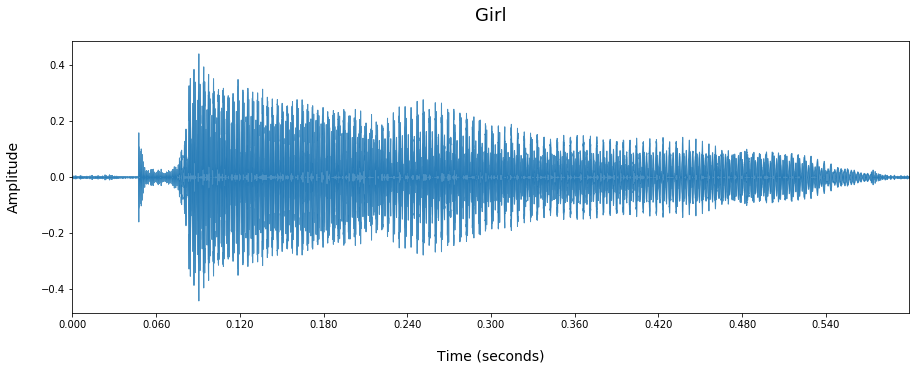

In [261]:
# Plot the isolated waveform for the specific audio sample
plt.figure(figsize=(15, 5))
plt.title('Girl', fontsize=18, pad=20)
librosa.display.waveplot(us_sample_isolated, sr, alpha=0.8)
plt.xlabel('Time (seconds)', fontsize=14, labelpad=20)
plt.ylabel('Amplitude', fontsize=14, labelpad=20)
plt.show();

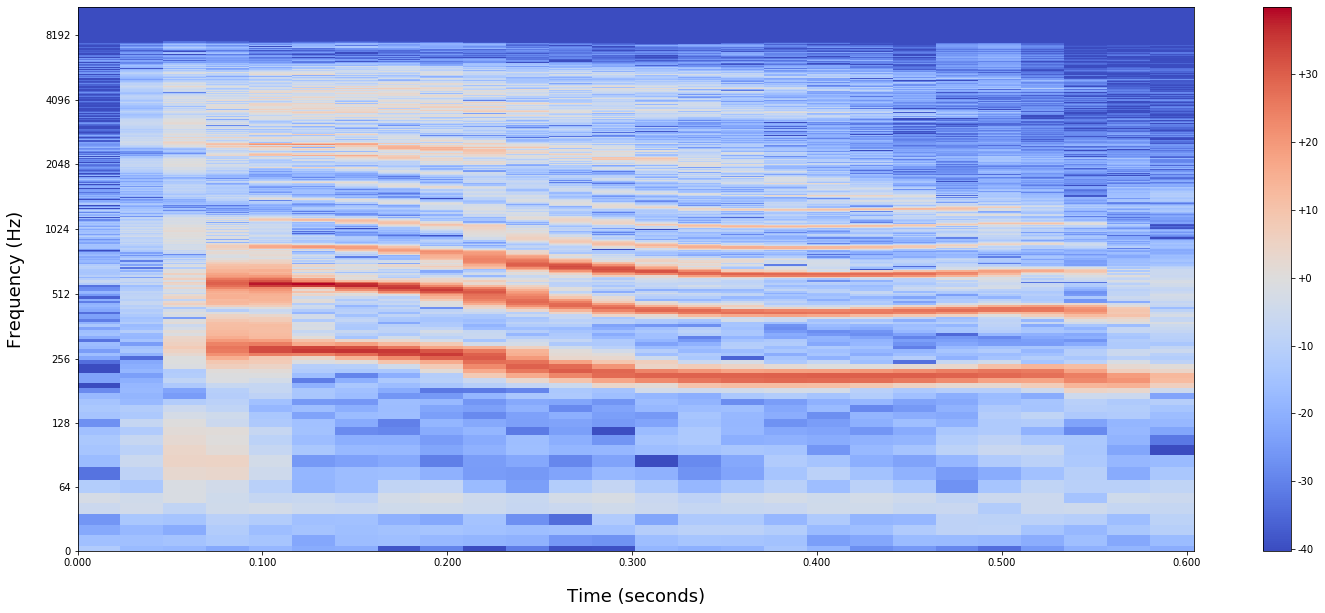

In [251]:
S_us_sample_iso = librosa.stft(us_sample_iso, n_fft=n_fft, hop_length=hop_length)
Y_us_sample_iso = np.abs(S_us_sample_iso) ** 2

Y_log_us_sample_iso = librosa.power_to_db(Y_us_sample_iso)

# Display spectrogram using log frequency
plot_spectrogram(Y_log_us_sample_iso, sr, hop_length, y_axis='log')